## Case 3：利用衛星影像計算同一區域在不同時期的植生變化情形

<div style="display: inline-block;">
    <img src="https://github.com/GISFCU-TM/GDXP-Demo/blob/main/FS2.png?raw=true" alt="FS2(2014)" width="360"/>
    <p style="text-align: center;">FS2(2014)</p>
</div>
<div style="display: inline-block;"> 
    <img src="https://github.com/GISFCU-TM/GDXP-Demo/blob/main/FS5.png?raw=true" alt="FS5(2018)" width="360"/>
    <p style="text-align: center;">FS5(2018)</p>      
</div>


### NDVI
常態化差值植生指標利用紅光與近紅外光的反射，能顯示出植物生長、生態系的活力與生產力等資訊。數值愈大表示植物生長狀況愈好。公式如下：
 - *NDVI = (NIR-RED)/(NIR+RED)*

NIR為近紅外光反射；RED為紅光反射，NDVI之值介於-1到1之間。 

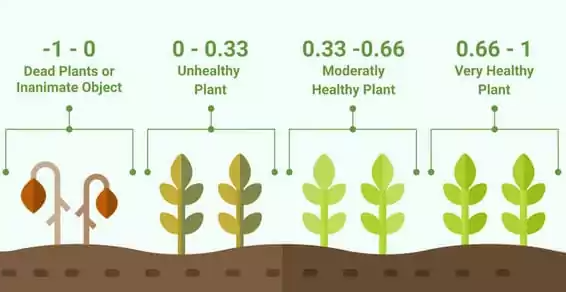

圖片來源：https://eos.com/blog/ndvi-faq-all-you-need-to-know-about-ndvi/


In [1]:
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 設定中文字形
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import requests
import numpy as np
import urllib3
urllib3.disable_warnings()

In [2]:
#GDXP帳號及介接安全碼
%store -r username
%store -r token
#GDXP URL
%store -r gdxp3

### NDVI強弱可視化

使用`switch-case`將NDVI分為五個區間，並以不同顏色顯示。

`switch-case`範例：

下列範例將藍色分配給$c coverage中所有像素值小於10的像素，將綠色分配給值大於等於10但小於20的像素，並將所有其他像素分配為黑色。

```
switch
  case $c < 10 return {red: 0; green: 0; blue: 255}
  case $c < 20 return {red: 0; green: 255; blue: 0}
  default return {red: 0; green: 0; blue: 0}
```

In [3]:
FS2NDVIpng='''
for $c in (FS2_MS_NSPO)
        return encode(
          ( switch
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0 return {red:255; green:0; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.25 return {red:255; green:128; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.5 return {red:255; green:255; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.75 return {red:50; green:205; blue:50}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 1.0 return {red:25; green:102; blue:25}             
             
              default       return {red:255; green:255; blue:255}
          ) [X(241996:255080), Y(2738036:2750180),ansi("2014-01-22T01:59:10.000Z")],
        "png") '''

In [4]:
FS5NDVIpng='''
for $c in (FS5_MS_NSPO)
        return encode(
        scale(
          ( switch
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0 return {red:255; green:0; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.25 return {red:255; green:128; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.5 return {red:255; green:255; blue:0}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 0.75 return {red:50; green:205; blue:50}
              case ( ((float) $c.band4_nir - $c.band1_red)/((float) $c.band4_nir + $c.band1_red) ) < 1.0 return {red:25; green:102; blue:25}                  
             
              default       return {red:255; green:255; blue:255}
          ) [X(241996:255080), Y(2738036:2750180),ansi("2018-12-17T02:58:13.000Z")],0.5),
        "png") '''

### 計算兩時期影像之NDVI變化

FS2解析度為8公尺；FS5解析度為4公尺。計算NDVI變化前，需先使用 `scale()` function將兩張影像之解析度調整一致。

In [5]:
NDVIdiff='''
for $c in (FS2_MS_NSPO),
    $d in (FS5_MS_NSPO)
let $csub := scale($c[X(241996:255080), Y(2738036:2750180),ansi("2014-01-22T01:59:10.000Z")], { X:"CRS:1"(0:1636) }),
    $dsub := scale($d[X(241996:255080), Y(2738036:2750180),ansi("2018-12-17T02:58:13.000Z")], { X:"CRS:1"(0:1636) })
        return encode( 
        switch
         case ((((float) $csub.band4_nir - $csub.band1_red)/((float) $csub.band4_nir + $csub.band1_red)))< (((float) $dsub.band4_nir - $dsub.band1_red)/((float) $dsub.band4_nir + $dsub.band1_red)) return {red:0; green:0; blue:0}
         case ((((float) $csub.band4_nir - $csub.band1_red)/((float) $csub.band4_nir + $csub.band1_red)))> (((float) $dsub.band4_nir - $dsub.band1_red)/((float) $dsub.band4_nir + $dsub.band1_red))return {red:255; green:255; blue:255}
         default       return {red:255; green:255; blue:255} 
          , "png")'''

In [6]:
# 送出 request
responsefs2 = requests.post(gdxp3, data = {'query': FS2NDVIpng}, verify=False, auth = (username, token))
responsefs5 = requests.post(gdxp3, data = {'query': FS5NDVIpng}, verify=False, auth = (username, token))
responsediff = requests.post(gdxp3, data = {'query': NDVIdiff}, verify=False, auth = (username, token))

# 將 Response 轉成 bytes 型態
fs2img = Image.open(BytesIO(responsefs2.content))
fs5img = Image.open(BytesIO(responsefs5.content))
diffimg= Image.open(BytesIO(responsediff.content))

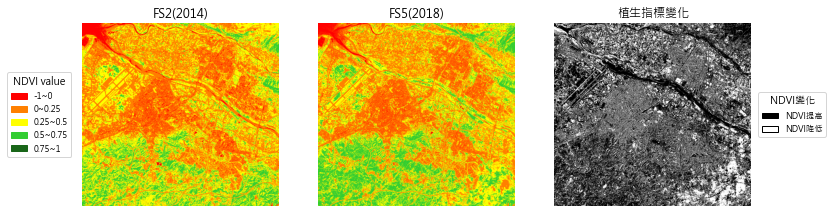

In [7]:
fig, ax = plt.subplots(1,3,figsize=(12, 12))

ax[0].set_title('FS2(2014)')
ax[0].imshow(fs2img)
ax[0].axis('off')

ax[1].set_title('FS5(2018)')
ax[1].imshow(fs5img)
ax[1].axis('off')

ax[2].set_title('植生指標變化')
ax[2].imshow(diffimg)
ax[2].axis('off')

red = mpatches.Patch(color='#ff0000', label='-1~0')
orange = mpatches.Patch(color='#ff8000', label='0~0.25')
yellow = mpatches.Patch(color='#ffff00', label='0.25~0.5')
green = mpatches.Patch(color='#32cd32', label='0.5~0.75')
darkgreen = mpatches.Patch(color='#196619', label='0.75~1')

black = mpatches.Patch(facecolor='#000000', edgecolor='#000000',label='NDVI提高')
white = mpatches.Patch(facecolor='#ffffff', edgecolor='#000000',label='NDVI降低')

ax[0].legend(handles=[red,orange,yellow,green,darkgreen],loc='center left', bbox_to_anchor=(-0.4, 0.5), title="NDVI value", fontsize='small')
ax[2].legend(handles=[black,white],loc='center right', bbox_to_anchor=(1.4, 0.5), title="NDVI變化", fontsize='small')
plt.show()